# P05: The Regression Pipeline -Training and Testing

This practical is best done only after you have gone through the lectures *L03:The Regression Pipeline*.

1. [Data Collection and Exploration](#1.0-Data-Collection-and-Exploration)
2. [Data Preprocessing](#2.0-Data-Preprocessing)
3. [Select and Train a Model](#3.0-Select-and-Train-a-Model)
   1. [Training a regression model](#3.1-Training-a-regression-model)
   2. [Evaluating a model using cross-validation](#3.2-Evaluating-a-model-using-cross-validation)
   3. [Fine-tune the model using Grid Search](#3.3-Fine-tune-the-model-using-Grid-Search)
4. [Evaluate system on unseen data (Test Set)](#4.0-Evaluate-system-on-unseen-data)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---
## 1.0 Data Collection and Exploration

We have gone through this portion of the code in great detail in the previous practical (P04).

In [2]:
# Load the dataset
print ('==> Loading the dataset...')
housing = pd.read_csv("housing.csv")
print ('done\n')


==> Loading the dataset...
done



---
## 2.0 Data Preprocessing

We have gone through this portion of the code in great detail in the previous practical (P04).

In [3]:
# Split the data set into the input matrix and output vector
X = housing.drop('median_house_value', axis = 1)
y = housing['median_house_value']

## Split the dataset into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# split the input matrix into numerical and categorical attributes
X_train_num  = X_train.drop('ocean_proximity', axis = 1)
X_train_cat  = X_train['ocean_proximity']

# Fill missing values with median
from sklearn.impute import SimpleImputer   
imputer = SimpleImputer(strategy = 'median')
imputer.fit(X_train_num)                              # compute the median     
X_train_num_tr = imputer.transform(X_train_num)       # fill up missing values with median value for the feature

# Standardize numeric data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy = False)
scaler.fit(X_train_num_tr)       
X_train_num_tr = scaler.transform(X_train_num_tr)

# One-hot encode categorical data
from sklearn.preprocessing import LabelBinarizer
lb_encoder = LabelBinarizer()
lb_encoder.fit(X_train_cat)
X_train_cat_tr = lb_encoder.transform(X_train_cat)       # returns numpy array

# combine the transformed numerical and categorical sets
X_train_tr = np.hstack([X_train_num_tr, X_train_cat_tr])
y_train = y_train.values;  #convert to numpy array
print('X_train_tr shape:', X_train_tr.shape)
print('y_train shape:', y_train.shape)

X_train_tr shape: (16512, 13)
y_train shape: (16512,)


---
## 3.0 Select and Train a Model

### 3.1 Training a regression model

Having preprocessed the data, in this step, we train a model to fit our dataset. We shall try three different models:
1. [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html): this is a linear model that uses a linear model to fit the data. The model is determined using Ordinary Least Squares. 
2. [DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html): this is a more powerful model capable of finding complex nonlinear relationship.
3. [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html): this is an ensemble model that trains many decision trees on random subsets of features and then average out their predictions.

**Notes**: For the purpose of this practical, it is not necessary for us to understand the details of how these machine learning algorithms work, for now. 

####  Model #1: Linear Regression model

First, let's try to fit the California *housing* dataset using the linear regression model ([LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)). The model uses the normal equation to solve the problem where it assumes that the data to be *linear*.

*Training the model*

The following code shows how to train a linear regression model. In Scikit-Learn, this commences in two simple step:

1. `lin_reg = LinearRegression()` creates the regressor object
2. `lin_reg.fit(X_train_tr, y_train)` trains our model on our training set (`X_train_tr`,`y_train`)

In [4]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_tr, y_train)

LinearRegression()

*Performance on training model*

Having fitted our dataset, we evaluate the performance of our model on the training set. First, let's use our model to predict the median house price (our targeted variable) for all samples in our training set itself. 

In [5]:
y_pred = lin_reg.predict(X_train_tr) # predict

Then, we display the predicted values for 10 random training samples 

In [21]:
def show10results(y_train, y_pred):
    print('Result for the 10 random samples:')
    selected = np.random.randint(0, len(y_train), 10)
    for i in selected:
        print('actual = {:7.0f} pred ={:7.0f}'.format(y_train[i], y_pred[i]))

show10results(y_train, y_pred)

Result for the 10 random samples:
actual =  500001 pred = 403701
actual =  195800 pred = 244211
actual =  266400 pred = 245658
actual =  159600 pred = 222640
actual =  213800 pred = 257374
actual =   92500 pred = 172032
actual =  137500 pred =  85066
actual =  171200 pred = 144961
actual =  201800 pred = 219032
actual =   88300 pred = 176675


To quantify how well our model fits the data, we shall use use the *Root Mean Squared Error* (RMSE) to evaluate the performance of our model:

<br><br> <center>$MSE = \frac{1}{m}\sum_{i=1}^m ({h(x^{(i)}) - y^{(i)}})^2$ </center>
<br> <center>$RMSE = \sqrt{MSE}$</center>
<br>   

In [22]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(y_pred, y_train)
lin_rmse = np.sqrt(lin_mse)
print('RMSE =', lin_rmse)

RMSE = 67862.00578972207


Comparing with the average `median_house_value` as computed below:

In [23]:
housing.median_house_value.mean()

206855.81690891474

*Discussion on result*:

Comparing with the average `median_house_value` of 206,855, a typical prediction error of 67,862 (67862/206855=33%) is not very satisfying. This is an example of **model underfitting**. When this happen, it means the features do not provide enough information to make good predictions or that the model is not powerful enough. 

We shall explore more powerful models.

#### Model #2: Decision Tree Regression Model

The Decision Tree Regressor (`DecisionTreeRegressor`) is a more powerful model compared to `LinearRegression` model. It is able to model non-linear relationships whereas `LinearRegression` could not.

**Exercise 1.** Build the regressor model using [DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and compute the RMSE of the training set. Set the `random_state` parameter to 42 as seed so that we get the same result each time we run the program. Then, predict the median house value on all training samples and randomly show the result for 10 randomly selected samples. Finally, compute the training RMSE.

In [26]:
from sklearn.tree import DecisionTreeRegressor

# create a instance of DecisionTreeRegressor
# tree_reg = ?
tree_reg = DecisionTreeRegressor(random_state=42)

# Train the regressor model
tree_reg.fit(X_train_tr, y_train)

# Predict on training set using trained regressor
y_pred = tree_reg.predict(X_train_tr)

# Show the result of 10 random samples
show10results(y_train, y_pred)

# Compute and show the RMSE on training set
tree_mse = mean_squared_error(y_pred, y_train)
tree_rmse = np.sqrt(tree_mse)
print('RMSE = ', tree_rmse)

Result for the 10 random samples:
actual =  245700 pred = 245700
actual =  350900 pred = 350900
actual =  194600 pred = 194600
actual =  218200 pred = 218200
actual =  281300 pred = 281300
actual =  128600 pred = 128600
actual =  465800 pred = 465800
actual =   75000 pred =  75000
actual =  416500 pred = 416500
actual =  275000 pred = 275000
RMSE =  0.0


You should see that we get an almost perfect result when we use DecisionTreeRegressor. The result is too good to be true. Indeed, later, we shall see that this model severely **overfits** our data.

#### Model #3: RandomForestRegressor model

Finally, we build the regressor model using `RandomForestRegressor` which builds an ensemble of decision trees. You shall see that it is the better model compared to `DecisionTreeRegressor` and `LinearRegression`. It has less of the overfitting issue and no underfitting issue. There is still a bit of an overfitting here, but it can be easily identified and resolved when we use cross-validation to fine-tune the model.  

**Exercise 2.** Build the regressor model using [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and compute the RMSE of the training set. Set parameter `n_estimators` to 10 and `random_state` to 42 as seed so that we get the same result each time we run the program.


In [28]:
from sklearn.ensemble import RandomForestRegressor

# create a instance of RandomForestRegressor
# forest_reg = ?
forest_reg = RandomForestRegressor(n_estimators = 10, random_state = 42)

# Train the regressor model
forest_reg.fit(X_train_tr, y_train)

# Predict on training set using trained regressor
y_pred = forest_reg.predict(X_train_tr)

# Show the result of 10 random samples
show10results(y_train, y_pred)

# Compute and show the RMSE on training set
forest_mse = mean_squared_error(y_train, y_pred)
forest_rmse = np.sqrt(forest_mse)
print('RMSE: ', forest_rmse)


Result for the 10 random samples:
actual =  156200 pred = 181910
actual =  118800 pred = 105610
actual =  110700 pred = 112100
actual =   73600 pred =  79720
actual =  210900 pred = 194980
actual =  134700 pred = 136750
actual =   56800 pred =  65730
actual =  105800 pred = 121260
actual =  184300 pred = 211500
actual =  266700 pred = 250380
RMSE:  21461.725210489367


#### Discussion on the training error
The RMSE results for the three models that we have built are summarized below:

| Model| Training RMSE|
|-----|-----|
| LinearRegresssion | 67862
| DecisionTreeRegressor | 0 |
| RandomForestRegressor | 21461 |

Here are some of the conclusions:
1. *LinearRegression may have underfitting issue*
   1. RMSE = 67862 is not a great score. The district's average median housing values is \$206,855. So, a RMSE score of 67,862 is high
   2. Likely encounter underfitting due to the high training error
   3. To solve underfitting model:
      1. Use a more powerful model
      2. Add more feature     
      <br>
2. *DecisionTreeRegressor may have overfitting issue*
   1. RMSE = 0 is too good
   2. Likely encounter overfitting due to a powerful model. To confirm, compute the cross-validation score (next section)
   3. To solve overfitting problem:
      1. Add more training samples
      2. Use less feature
      3. Perform regularization    
      <br>
3. *RandomForestRegressor*
   1. Deliver the best result among the three models
   2. May still have a bit of overfitting, but this can be easily identified and resolved through cross-validation.

#### Issues to be resolved next: 
There are several issues with the the models we have created just now.
1. Evaluating directly on the training set is misleading because the RMSE score will very likely be over-optimistic. We shall get more accurate scores through cross-validation (discuss next). Selecting the model with the best cross-validation score reduces  overfitting to a certain degree.
2. We have not tuned our model. Since fine-tuning on the testing set is strictly prohibited, we need a validation set to tune our model. 

Next, we shall validate and fine-tune our model using **cross-validation** next.


---
### 3.2 Evaluating a model using cross-validation

It is a common practice to perform **cross-validation** where a  portion of the training set is set aside specifically for evaluation and fine-tuning purposes. The data being set aside is called the **validation set**. 

There are different ways to perform cross-validation:
1. Hold-out validation
2. k-fold cross-out validation

In the following, we shall implement the k-fold cross-out validation

#### Cross-validation on Model #1: Linear Regression model

In the following, we will perform a 5-fold cross validation on the LinearRegression Model. The Scikit-Learn library provides the function [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to perform k-fold cross-validation easily.

The command
```
k_fold_scores = cross_val_score(lin_reg, X_train_tr, y_train, scoring = 'neg_mean_squared_error', cv=5)
```
performs the 5-fold cross validation:


1. In each iteration:
   1. One (unevaluated) fold is used to evaluate the performance of the model.  
   1. The remaining four folds are used to train a model using the preditor `lin_reg` on the training set (`X_train_tr`, `y_train`)   
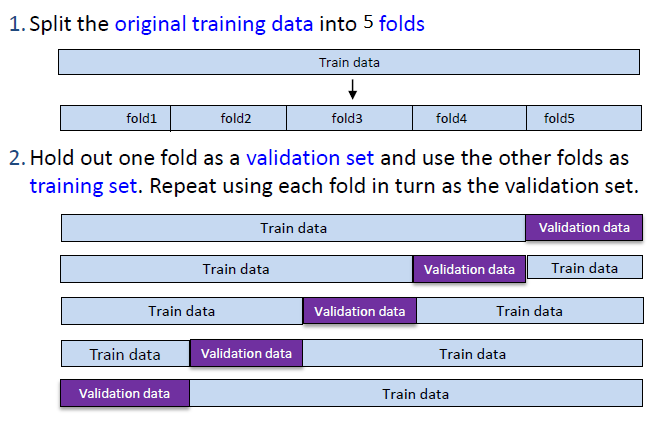
<br>
2. The function returns the negative mean squared error (NMSE) by setting `scoring = neg_mean_squared_error`. It does so since it uses a utility function to maximize the final score rather than a cost function that minimizes the final score. The negative mean squared error is defined as: 
<br><br> <center>$NMSE = -MSE$</center>
<br>   
3. In order to get back the root mean squared error (RMSE) from the negative mean squared error (`neg_mean_squared_error`) compute $RMSE = \sqrt{-NMSE}$:
```
linreg_rmse_scores = np.sqrt(-scores)
```

In [29]:
from sklearn.model_selection import cross_val_score

k_fold_scores = cross_val_score(lin_reg, X_train_tr, y_train, 
                                scoring = 'neg_mean_squared_error', cv=5)

linreg_rmse_scores = np.sqrt(-k_fold_scores)

The following shows the validation score across all 5 folds. The average of these scores (**average cross-validation score**) is a more accurate performance measure compared to the *training score*. The standard deviation further tell us the predictor's reliability (if it is too high, the cross-validation error could be imprecise).

In [30]:
def display_scores(scores):
    print('Scores:', scores, '\n')
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(linreg_rmse_scores)

Scores: [69433.4768204  68307.7221487  68301.117204   67566.73279258
 66257.83374294] 

Mean: 67973.37654172447
Standard deviation: 1044.9440160651611


**Notes**: the function `cross_val_score` **will not update our model `lin_reg` with any of the fitted models**. This is because `cross_val_score` makes a copy of `lin_reg` and train using only the copy version. Consequently, none of the models built are saved.

#### Cross-validation on Model #2: Decision Tree Regressor

**Exercise 3.** Perform a 5-fold cross validation on DecisionTreeRegressor and show the scores.


In [31]:
# use cross_val_score on tree_reg
k_fold_scores = cross_val_score(tree_reg, X_train_tr, y_train, scoring = 'neg_mean_squared_error', cv=5)

# covert NMSE to RMSE
treereg_rmse_scores = np.sqrt(-k_fold_scores)

# use display_scores to show the results
display_scores(treereg_rmse_scores)

Scores: [70622.2277572  68670.10432599 72373.00128251 70048.86301873
 70337.26503253] 

Mean: 70410.29228339181
Standard deviation: 1188.3906327522175


#### Cross-validation on Model #3: Random Forest Regressor

**Exercise 4.** Perform a 5-fold cross validation on RandomForestRegressor and show the scores. 


In [32]:
# use cross_val_score on forest_reg
k_fold_scores = cross_val_score(forest_reg, X_train_tr, y_train, scoring = 'neg_mean_squared_error', cv=5)

# covert NMSE to RMSE
forestreg_rmse_scores = np.sqrt(-k_fold_scores)

# use display_scores to show the results
display_scores(forestreg_rmse_scores)

Scores: [53420.4430479  51624.04916673 52572.20796094 51320.53310458
 51717.49813802] 

Mean: 52130.94628363521
Standard deviation: 767.0941728264665


---
### 3.3 Fine-tune the model using Grid Search

In the previous step, we have learnt how to *evaluate the performance* of a model using *cross-validation*. We can also use cross-validation to **fine-tune the model**. Each model comes with different **hyperparameters**. Hyperparameters are the settings of a machine learning that needs to be set prior to training. 
To find the best hyperparameter values for these settings, we shall use the Grid Search. 

#### Finding the best hyperparameter for *RandomForestRegressor* using Grid Search

Let's take *RandomForestRegressor* as our test case.  RandomForestRegressor is a meta estimator where the decision tree classifier is trained on different sub-samples of the dataset, thus generating different models. The result from the models are averaged to improve the predictive accuracy and control over-fitting. The hyperparameters for RandomForestRegressor are:
1. `n_estimators`: The number of trees in the forest. 
2. `max_features`: The number of features to consider when looking for the best split. This is a hyperparameter for decision tree classifier. There is no need for us to know in detail how decision tree works to go through this practical.
3. `bootstrap`: Whether bootstrap samples are used when building trees. If bootstrap = True, the sub-sample size is always the same as the original input sample size but the samples are drawn with replacement

**Defining the grid to search**
1. `n_estimators`: [12, 20, 28] 
2. `max_features`: [4, 6, 8]
3. `bootstrap`: [True, False]

The total models generated and evaluated is 3 x 3 x 2 = 18 models.






In [ ]:
param_grid = {'bootstrap': [True, False],'n_estimators': [12, 20, 28], 'max_features':[4, 6, 8]}

**Performing grid search**
<br>
The following code shows how to perform a grid search using Scikit-Learn [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). 

  1. Create our predictor (machine learning) object. Here, we use the *RandomForestRegressor*. 
<br> `forest_reg = RandomForestRegressor(random_state=42)`   
<br> 
  2. Create the grid search object, during which we specify the predictor object, the number of folds and the scoring measure.
`grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error')`
     * `forest_reg` is the machine learning object used to build the model
     * `param_grid` is the hyperparameter settings to be evaluated
     * `cv=5` means 5-fold cross validation
     * `scoring = 'neg_mean_squared_error'` uses the negative mean squared error for evaluation   
<br>
  3. Then, we perform grid search using the `.fit` command. This will take some time.
<br>`grid_search.fit(X_train_tr, y_train)`
     * Performs the fine-tuning process. 
     * In our case, a total of 18 models would be trained using the 18 different settings mentioned above. 

**Exercise 5.** Write code to perform grid search and 5-fold cross-validation to find the best model using a RandomForestRegressor.

In [33]:
from sklearn.model_selection import GridSearchCV

# create an instance of RandomForestRegressor(random_state=42)
# forest_reg = ?
forest_reg = RandomForestRegressor(random_state = 42)

# define param_grid (you may used the one defined above)
# param_grid = ?
param_grid = {'bootstrap': [True, False],'n_estimators': [12, 20, 28], 'max_features':[4, 6, 8]}

# create an instance of GridSearchCV using param_grid with 5-fold cv
# grid_search = ?
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error')

print ('Performing grid search...', end = '')
# perform grid search
grid_search.fit(X_train_tr, y_train)

print('done')

Performing grid search...done


We can get the **best model** out of all 18 models trained by grid search through the command `grid_search.best_estimator_`. You may want to save this model to be used for final testing or deployment later. 

In [34]:
best_model = grid_search.best_estimator_
best_model

RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=28,
                      random_state=42)

We can get the **hyperparameter** and **average cv score** (negative mean square error) for the **best performing model** through the command `grid_search.best_params` and `grid_search.best_score_`, respectively. 

In [35]:
print('Best hyperparameter settings:', grid_search.best_params_)
print('RMSE of the best model =', np.sqrt(-grid_search.best_score_))

Best hyperparameter settings: {'bootstrap': False, 'max_features': 6, 'n_estimators': 28}
RMSE of the best model = 49091.53705337537


The RMSE of the best model is 49091, which is lower than the model we trained earlier earlier (RMSE=52130)
<br><br>
We may gain good insights on the importance of each of the attributes by inspecting the best models!


In [36]:
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = X_train_num.columns.tolist() + list(lb_encoder.classes_)
sorted(zip(feature_importances, attributes), reverse=True)

[(0.40900382338455427, 'median_income'),
 (0.1537660629470213, 'INLAND'),
 (0.12386142081414621, 'longitude'),
 (0.11580576492874449, 'latitude'),
 (0.04305951901487116, 'housing_median_age'),
 (0.04134372370292811, 'population'),
 (0.03336537848842255, 'total_rooms'),
 (0.02721747607203158, 'total_bedrooms'),
 (0.025701863206500086, 'households'),
 (0.015536557838347415, '<1H OCEAN'),
 (0.005916999372287639, 'NEAR OCEAN'),
 (0.005001399210138566, 'NEAR BAY'),
 (0.00042001102000676857, 'ISLAND')]

From the results, it is clear that median_income is the most important predictor, followed by location features (INLAND, longtitude, latitude).

--- 
## 4.0 Evaluate system on unseen data

Having trained and fine-tuned our model, we are almost ready to deploy our model. But before this, we shall do one final test by evaluating our best model on the test set.


### 4.1 How to use the test set

***Warning: Never use the test set to build or refine your model in any way***

It is a golden rule of thumb that we must evaluate on the test set only at the every end of your development cycle to evaluate how well your model works on new data. Test set are used to evaluate how well our model can generalizes to new unseen data. In this sense, the test set is used only for reporting purposes where the reported accuracy ideally is closer to the expected performance when we deploy our model.

The test set must never be used in any way to build or fine-tune the model. 

### 4.2 Preprocessing the test set

All unseen data should go through the **same preprocessing steps** as the training set. This ensures that the features for the unseen data resides in the same space as the training set. 

We have already set aside a test set and have separated it into input matrix *X_test* and output vector *y_test*. Next, we need to further process the test set.
<br>

**Exercise 6.** Split `X_test` into `X_test_num` (numerical features only) and `X_test_cat` (categorical features only)

Ans:

1. Ensure that the arrays have the following shapes:
   1. Shape of X_test_num: (4128, 8)
   2. Shape of X_test_cat: (4128,)
2. Ensure that `X_test_num` does not contain the column `ocean_proximity` 
3. Ensure that `X_test_cat` stores the value of `ocean_proximity` 

In [37]:
# Split the test set into numerical and categorical sets
X_test_num = X_test.drop('ocean_proximity', axis=1)
X_test_cat = X_test.ocean_proximity

In [38]:
print('Shape of X_test_num:', X_test_num.shape)
print('Shape of X_test_cat:', X_test_cat.shape)

Shape of X_test_num: (4128, 8)
Shape of X_test_cat: (4128,)


**Exercise 7.** Missing value the missing values. For the *training set*, we fill the missing value with the median value of a column. For *unseen data*, we must use the **same** median value used in the training set. To do this, you must use the same `imputer` object that you fit using the training set.

In [39]:
# fill missing values on test set (use the imputer from section 2)
X_test_num_tr = imputer.transform(X_test_num) ##Dont fit again


**Exercise 8.** Standardize the data as performed on the training set. Similarly, you should use the **same** mean and standard deviation value used on the training set. To do this, you must use the same `scaler` object that you fit using the training set.

In [40]:
# standardize the numerical attributes in test set (use the scaler from section 2)
X_test_num_tr = scaler.transform(X_test_num_tr)

**Exercise 9.** Convert the categorical attribute into one-hot vector. Similarly, you should use the same `lb_encoder` to convert the categorical data to a one-hot vector.

In [41]:
# one-hot encode the categorical attribute in the test set (use the lb_encoder from section 2)
X_test_cat_tr = lb_encoder.transform(X_test_cat)

Lastly, we combine the numerical and categorical sets

In [42]:
# combine the numerical and categorical sets using hstack
X_test_tr = np.hstack((X_test_num_tr, X_test_cat_tr))

#### Predicting on the test set

**Exercise 10.** Evaluate the best model on test set and compute the RMSE for the test set.


In [45]:
#  Evaluate the best model on test set and compute the RMSE
y_pred = best_model.predict(X_test_tr) ##Dont fit anymore

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE = ', rmse)

Test RMSE =  50712.6789228979


Test performance is usually slightly worse than validation performance since the model is fine-tuned to perform well on the validation data.

**---- End ----**